<a href="https://colab.research.google.com/github/MatheusBigg/dio_datascience_bootcamp/blob/main/Reconhecimento_Facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics opencv-python matplotlib mtcnn dlib cmake facenet_pytorch torch torchvision --quiet

import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Javascript, HTML
from PIL import Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from ultralytics import YOLO
from mtcnn import MTCNN
import io
#import face_recognition
import os
from google.colab import files
import torch
from facenet_pytorch import InceptionResnetV1, MTCNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21

In [2]:
#captura refeita
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            div.style.textAlign = 'center';
            div.style.padding = '20px';
            div.style.border = '2px solid #333';
            div.style.borderRadius = '10px';
            div.style.marginBottom = '10px';

            const capture = document.createElement('button');
            capture.textContent = '📸 Capturar Foto';
            capture.style.padding = '10px 20px';
            capture.style.fontSize = '16px';
            capture.style.backgroundColor = '#4CAF50';
            capture.style.color = 'white';
            capture.style.border = 'none';
            capture.style.borderRadius = '5px';
            capture.style.cursor = 'pointer';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            video.style.margin = '10px auto';
            video.style.border = '2px solid #ddd';
            video.style.borderRadius = '10px';

            const stream = await navigator.mediaDevices.getUserMedia({
                video: { width: 640, height: 480, facingMode: 'user' }
            });

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

In [3]:
def read_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Erro ao carregar imagem.")
    return img

def show_image(img, title='Imagem'):
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Detector Wrapper
class FaceDetectors:
    def __init__(self):
        self.detectors = {
            'yolo': self._setup_yolo(),
            'opencv': self._setup_opencv(),
            'mtcnn': self._setup_mtcnn()
        }

    def _setup_yolo(self):
        try:
          if not os.path.exists('yolov8n-face.pt'):
            !wget -q https://github.com/akanametov/yolov8-face/releases/download/v0.0.0/yolov8n-face.pt
        except:
            print("Falha ao baixar yolov8n-face.pt, usando yolov8n.pt")
        return YOLO('yolov8n-face.pt')

    def _setup_opencv(self):
        face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        eye = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
        return (face, eye)

    def _setup_mtcnn(self):
        return MTCNN()

# Detecção unificada
def detect_faces(image_path, method='yolo', detectors=None):
    img = read_image(image_path)

    if method == 'yolo':
        model = detectors['yolo']
        results = model(img, conf=0.3)
        faces = results[0].boxes
        annotated = results[0].plot()
        show_image(annotated, 'YOLO Face Detection')
        return len(faces)

    elif method == 'opencv':
        face_cascade, eye_cascade = detectors['opencv']
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        show_image(img, 'OpenCV Face Detection')
        return len(faces)

    elif method == 'mtcnn':
        detector = detectors['mtcnn']
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        detections = detector.detect_faces(rgb_img)
        for det in detections:
            x, y, w, h = det['box']
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        show_image(img, 'MTCNN Face Detection')
        return len(detections)

    else:
        raise ValueError("Método inválido: escolha entre 'yolo', 'opencv' ou 'mtcnn'.")


<IPython.core.display.Javascript object>


0: 480x640 2 faces, 100.6ms
Speed: 1.4ms preprocess, 100.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


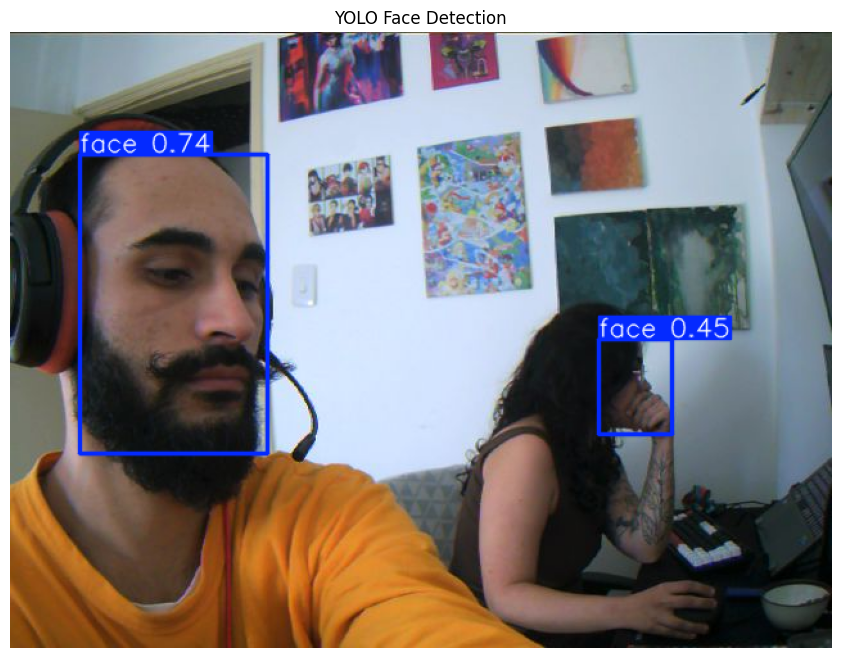

YOLO detectou 2 rosto(s)


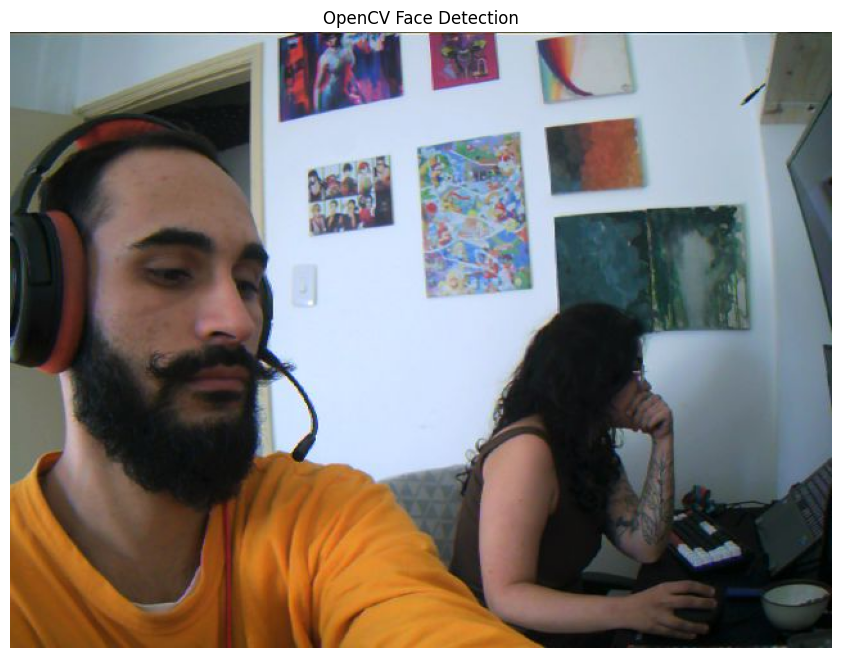

OPENCV detectou 0 rosto(s)


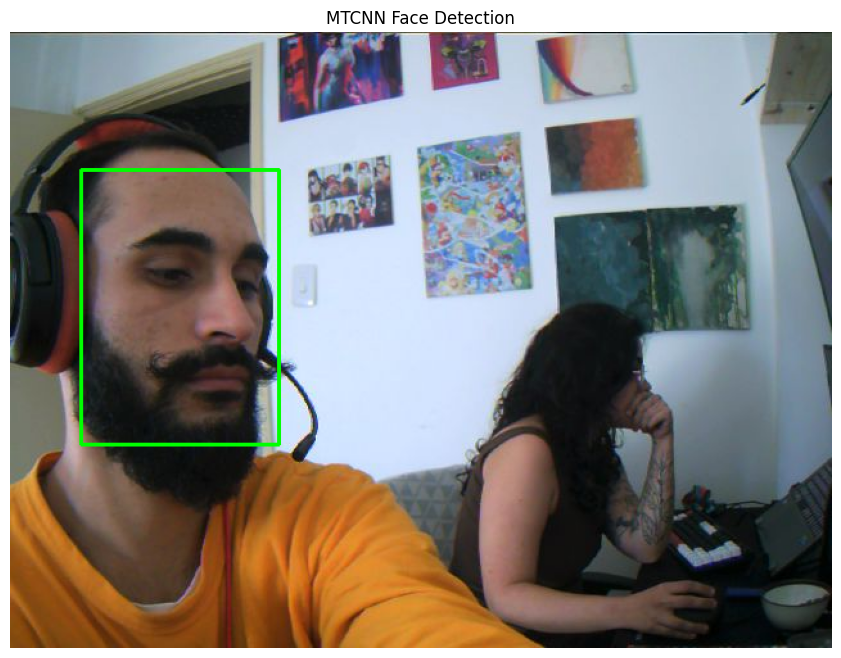

MTCNN detectou 1 rosto(s)


In [ ]:
detectors = FaceDetectors().detectors
image_path = take_photo('foto.jpg')

for method in ['yolo', 'opencv', 'mtcnn']:
    count = detect_faces(image_path, method, detectors)
    print(f"{method.upper()} detectou {count} rosto(s)")

In [4]:
# Pastas necessárias
pastas = ['known_faces', 'unknown_faces']
for pasta in pastas:
    os.makedirs(pasta, exist_ok=True)

print("Pastas prontas:")
print(os.listdir())
print("Suba as imagens de pessoas para detectar (minimo 10 por pessoa):")
uploaded = files.upload()
for filename in uploaded.keys():
  print(f'Movendo "{filename}" para a pasta "known_faces"...')
  !mv "{filename}" known_faces/

print("\nVerificando o conteúdo da pasta 'known_faces':")
!ls known_faces/

Pastas prontas:
['.config', 'known_faces', 'unknown_faces', 'sample_data']
Suba as imagens de pessoas para detectar (minimo 10 por pessoa):


Saving Cameron_1.jpg to Cameron_1.jpg
Saving Cameron_2.jpeg to Cameron_2.jpeg
Saving Cameron_3.jpg to Cameron_3.jpg
Saving Cameron_4.jpg to Cameron_4.jpg
Saving Cameron_5.jpg to Cameron_5.jpg
Saving Cameron_6.jpg to Cameron_6.jpg
Saving Cameron_7.jpg to Cameron_7.jpg
Saving Cameron_8.jpg to Cameron_8.jpg
Saving Cameron_9.jpg to Cameron_9.jpg
Saving Cameron_10.jpg to Cameron_10.jpg
Saving Chase_1.jpg to Chase_1.jpg
Saving Chase_2.jpg to Chase_2.jpg
Saving Chase_3.jpg to Chase_3.jpg
Saving Chase_4.jpg to Chase_4.jpg
Saving Chase_5.jpg to Chase_5.jpg
Saving Chase_6.jpg to Chase_6.jpg
Saving Chase_7.jpg to Chase_7.jpg
Saving Chase_8.jpg to Chase_8.jpg
Saving Chase_9.jpg to Chase_9.jpg
Saving Chase_10.jpg to Chase_10.jpg
Saving Foreman_1.jpg to Foreman_1.jpg
Saving Foreman_2.jpg to Foreman_2.jpg
Saving Foreman_3.jpg to Foreman_3.jpg
Saving Foreman_4.jpg to Foreman_4.jpg
Saving Foreman_5.jpg to Foreman_5.jpg
Saving Foreman_6.jpg to Foreman_6.jpg
Saving Foreman_7.jpg to Foreman_7.jpg
Saving F

In [5]:
# Instanciar a classe e os modelos de reconhecimento
detectors_instance = FaceDetectors()
mtcnn_detector = detectors_instance.detectors['mtcnn']
resnet_model = InceptionResnetV1(pretrained='vggface2').eval()

# Geração de embeddings
known_embeddings = []
known_names = []

print("Gerando embeddings para as faces conhecidas...")
for filename in os.listdir('known_faces'):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        person_name = filename.split('_')[0]
        img_path = f'known_faces/{filename}'
        img = cv2.imread(img_path)

        # Detectar rostos com MTCNN
        boxes, _ = mtcnn_detector.detect(img)

        if boxes is not None:
            # Extrair e alinhar os rostos para o FaceNet
            faces = mtcnn_detector.extract(img, boxes, None)

            if faces.dim() == 3:
              faces = faces.unsqueeze(0)

            # Gerar embeddings com FaceNet
            with torch.no_grad():
                embeddings = resnet_model(faces).detach().cpu().numpy()

            for embedding in embeddings:
                known_embeddings.append(embedding)
                known_names.append(person_name)
            print(f"✅ Imagem {filename} processada. Encontradas {len(embeddings)} faces.")
        else:
            print(f"❌ Nenhuma face encontrada em {filename}")

known_embeddings = np.array(known_embeddings)
known_names = np.array(known_names)

  0%|          | 0.00/107M [00:00<?, ?B/s]

Gerando embeddings para as faces conhecidas...
✅ Imagem Cameron_3.jpg processada. Encontradas 1 faces.
✅ Imagem LisaCuddy_1.jpg processada. Encontradas 1 faces.
✅ Imagem Wilson_7.jpg processada. Encontradas 1 faces.
✅ Imagem Chase_2.jpg processada. Encontradas 1 faces.
✅ Imagem Foreman_2.jpg processada. Encontradas 1 faces.
✅ Imagem House_2.jpg processada. Encontradas 1 faces.
✅ Imagem Chase_8.jpg processada. Encontradas 1 faces.
✅ Imagem Cameron_2.jpeg processada. Encontradas 1 faces.
✅ Imagem LisaCuddy_9.jpg processada. Encontradas 1 faces.
❌ Nenhuma face encontrada em Foreman_4.jpg
✅ Imagem House_6.jpg processada. Encontradas 1 faces.
✅ Imagem Chase_10.jpg processada. Encontradas 1 faces.
❌ Nenhuma face encontrada em Foreman_8.jpg
✅ Imagem Chase_1.jpg processada. Encontradas 1 faces.
✅ Imagem Wilson_10.jpg processada. Encontradas 1 faces.
✅ Imagem LisaCuddy_10.jpg processada. Encontradas 1 faces.
✅ Imagem Foreman_7.jpg processada. Encontradas 1 faces.
✅ Imagem Cameron_10.jpg process


Suba a imagem para reconhecer:


Saving house_elenco2.jpg to house_elenco2 (1).jpg
Rostos detectados: 9
Rosto 1: LisaCuddy (0.95)
Rosto 2: House (0.84)
Rosto 3: Chase (0.89)
Rosto 4: Desconhecido (1.17)
Rosto 5: Desconhecido (1.15)
Rosto 6: Wilson (0.89)
Rosto 7: Foreman (0.67)
Rosto 8: Desconhecido (1.17)
Rosto 9: Cameron (0.68)


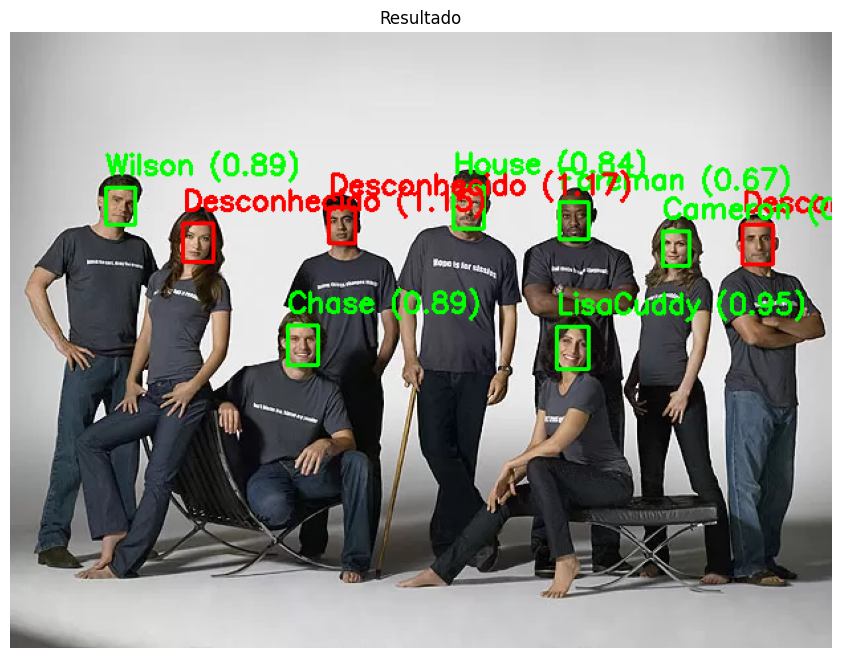

In [29]:
print("\nSuba a imagem para reconhecer:")
uploaded = files.upload()
if not uploaded:
    print("Nenhuma imagem enviada.")
else:
    test_img_path = list(uploaded.keys())[0]
    img = cv2.imread(test_img_path)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    temp_img = img.copy()

    # Detecção com MTCNN
    boxes, _ = mtcnn_detector.detect(img)

    if boxes is not None:
        print(f"Rostos detectados: {len(boxes)}")

        # Extração e normalização dos rostos
        faces = []
        valid_boxes = []
        for box in boxes:
            x1, y1, x2, y2 = box.astype(int)
            face_img = rgb_img[y1:y2, x1:x2]
            if face_img.size > 0:
                face_resized = cv2.resize(face_img, (160, 160))
                face_normalized = (face_resized.astype(np.float32) - 127.5) / 128.0 #Pra ficar -1 a 1
                faces.append(face_normalized)
                valid_boxes.append(box)

        if faces:
            # Converte para tensor
            face_tensors = torch.stack([torch.from_numpy(f.transpose(2,0,1)).float() for f in faces])

            # Gera embeddings
            with torch.no_grad():
                test_embeddings = resnet_model(face_tensors).cpu().numpy()

            # Reconhecimento
            for i, (box, emb) in enumerate(zip(valid_boxes, test_embeddings)):
                x1, y1, x2, y2 = box.astype(int)
                distances = np.linalg.norm(known_embeddings - emb, axis=1)
                min_dist = np.min(distances)

                if min_dist < 1.0:  # Threshold
                    name = known_names[np.argmin(distances)]
                    color = (0, 255, 0)
                    label = f"{name} ({min_dist:.2f})"
                else:
                    name = "Desconhecido"
                    color = (0, 0, 255)
                    label = f"{name} ({min_dist:.2f})"

                cv2.rectangle(temp_img, (x1, y1), (x2, y2), color, 2)
                cv2.putText(temp_img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
                print(f"Rosto {i+1}: {label}")

            show_image(temp_img, 'Resultado')
        else:
            print("Nenhum rosto válido encontrado.")
    else:
        print("Nenhum rosto detectado.")

**Reconheceu corretamente todos**

*(Thirteen, Taub e Kutner eu não tinha treinado, mas tb reconhece que são rostos)*